In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2 

In [2]:
import os
import datajoint as dj
dj.config['database.host'] = os.environ['DJ_HOST']
dj.config['database.user'] = os.environ['DJ_USER']
dj.config['database.password'] = os.environ['DJ_PASS']
dj.config['enable_python_native_blobs'] = True

name = "simdata"
dj.config['schema_name'] = f"konstantin_nnsysident_{name}"

In [3]:
import torch
import numpy as np
import pickle 
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
import matplotlib.pyplot as plt
import re
import seaborn as sns

import nnfabrik
from nnfabrik.main import *
from nnfabrik import builder
from nnfabrik.utility.hypersearch import Bayesian

from nnsysident.tables.experiments import *
from nnsysident.tables.bayesian import *
from nnsysident.datasets.mouse_loaders import static_shared_loaders
from nnsysident.datasets.mouse_loaders import static_loaders
from nnsysident.datasets.mouse_loaders import static_loader

Connecting konstantin@sinzlab.chlkmukhxp6i.eu-central-1.rds.amazonaws.com:3306
Schema name: konstantin_nnsysident_simdata


In [4]:
def get_transfer():
    # prepare the Transfer table in a way that all the info about the transferred model is in the DataFrame. Just pd.merge (on transfer_fn and transfer_hash)
    # it then with the model that the transferred model was used for. 
    transfer = pd.DataFrame(Transfer.fetch())
    transfer = pd.concat([transfer, transfer['transfer_config'].apply(pd.Series)], axis = 1).drop('transfer_config', axis = 1)

    tm = pd.DataFrame((TrainedModel * Dataset).fetch()).rename(
        columns = {'model_hash': 't_model_hash', 'trainer_hash': 't_trainer_hash', 'dataset_hash': 't_dataset_hash'})

    transfer = pd.merge(transfer, tm, how='inner', on=['t_model_hash', 't_trainer_hash', 't_dataset_hash'])
    transfer = pd.concat([transfer, transfer['dataset_config'].apply(pd.Series)], axis = 1).drop('dataset_config', axis = 1)
    transfer.columns = ['t_' + col if col[:2] != 't_' and col[:8] != 'transfer'  else col for col in transfer.columns]
    return transfer

### Directly trained

In [ ]:
data = pd.DataFrame()
for experiment_name in ['SIM, Direct, se2d_spatialxfeaturelinear, 0-0-3', 'SIM, Direct, se2d_pointpooled, 0-0-3', 'SIM, Direct, se2d_fullgaussian2d, 0-0-3']:
    data_ = pd.DataFrame((TrainedModel * Dataset * Model * Trainer * Seed * Experiments.Restrictions & 'experiment_name="{}"'.format(experiment_name)).fetch())
    data = pd.concat([data, data_])
    
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1).drop('dataset_config', axis = 1)
data = pd.concat([data, data['model_config'].apply(pd.Series)], axis = 1).drop('model_config', axis = 1)
data['readout'] = [row.model_fn.split('.')[-1] for loc, row in data.iterrows()]


In [ ]:
title = 'Directly trained, simulated data, different readouts'
neuron_n = 1000

hues = np.unique(data.readout.values)
fig, ax = plt.subplots(1, 1, figsize=(10,10))

sns.set_context('notebook', font_scale=1.45)
pal = sns.color_palette('colorblind', n_colors=len(hues))
sns.set_palette(pal)
with sns.axes_style('ticks'):
    g = sns.pointplot('image_n', "score", hue='readout', data=data.loc[data['neuron_n'] == neuron_n], 
                hue_order=hues, ax=ax)

    sns.despine(trim=True)
    g.axes.set_ylabel('validation correlation') 
    g.axes.set_xlabel('images') 
    plt.legend(loc='lower right', bbox_to_anchor=(0.99, 0.05), ncol=1, frameon=False, prop={'size': 15.})
    plt.title(title)
    
    #g.figure.savefig(title + '.png', dpi=150)

### core-transfer (sameNI)

In [ ]:
# core-transfer (sameNI)
data = pd.DataFrame()
transfer = get_transfer()
for experiment_name in ["SIM, core_transfer (sameNI), se2d_fullgaussian2d, 0-0-3 -> 0-0-3",
                        "SIM, core_transfer (sameNI), se2d_pointpooled, 0-0-3 -> 0-0-3",
                        "SIM, core_transfer (sameNI), se2d_spatialxfeaturelinear, 0-0-3 -> 0-0-3"]:
    data_ = pd.DataFrame((TrainedModelTransfer * Dataset * Model * Trainer * Seed * Transfer.proj() * ExperimentsTransfer.Restrictions & 'experiment_name="{}"'.format(experiment_name)).fetch())
    data_ = pd.merge(data_, transfer, how='inner', on=['transfer_hash', 'transfer_fn'])
    data = pd.concat([data, data_])
data['readout'] = [row.model_fn.split('.')[-1] for loc, row in data.iterrows()]

In [ ]:
title = 'core-transfer (sameNI), simulated data, neurons:1000, images:4000'
t_neuron_n = 1000

hues = np.unique(data.readout.values)
fig, ax = plt.subplots(1, 1, figsize=(10,10))

sns.set_context('notebook', font_scale=1.45)
pal = sns.color_palette('colorblind', n_colors=len(hues))
sns.set_palette(pal)
with sns.axes_style('ticks'):
    g = sns.pointplot('t_image_n', "score", hue='readout', data=data.loc[data['t_neuron_n'] == t_neuron_n], 
                hue_order=hues, ax=ax)

    sns.despine(trim=True)
    g.axes.set_ylabel('validation correlation') 
    g.axes.set_xlabel('images used to train the transferred core') 
    plt.legend(loc='lower right', bbox_to_anchor=(0.99, 0.05), ncol=1, frameon=False, prop={'size': 15.})
    plt.title(title)
    
    #g.figure.savefig(title + '.png', dpi=150)

### core-transfer (best)

In [9]:
# core-transfer (sameNI)
data = pd.DataFrame()
transfer = get_transfer()
for experiment_name in ["SIM, core_transfer (best), se2d_fullgaussian2d, 0-0-3 -> 0-0-3",
                         "SIM, core_transfer (best), se2d_pointpooled, 0-0-3 -> 0-0-3",
                         "SIM, core_transfer (best), se2d_spatialxfeaturelinear, 0-0-3 -> 0-0-3"]:
    data_ = pd.DataFrame((TrainedModelTransfer * Dataset * Model * Trainer * Seed * Transfer.proj() * ExperimentsTransfer.Restrictions & 'experiment_name="{}"'.format(experiment_name)).fetch())
    data_ = pd.merge(data_, transfer, how='inner', on=['transfer_hash', 'transfer_fn'])
    data = pd.concat([data, data_])
data['readout'] = [row.model_fn.split('.')[-1] for loc, row in data.iterrows()]
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1).drop('dataset_config', axis = 1)

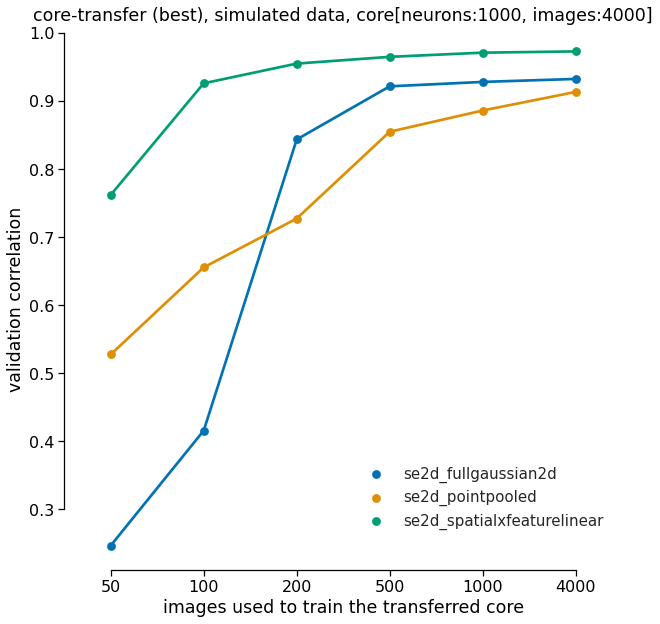

In [10]:
title = 'core-transfer (best), simulated data, core[neurons:1000, images:4000]'
neuron_n = 1000

hues = np.unique(data.readout.values)
fig, ax = plt.subplots(1, 1, figsize=(10,10))

sns.set_context('notebook', font_scale=1.45)
pal = sns.color_palette('colorblind', n_colors=len(hues))
sns.set_palette(pal)
with sns.axes_style('ticks'):
    g = sns.pointplot('image_n', "score", hue='readout', data=data.loc[data['neuron_n'] == neuron_n], 
                hue_order=hues, ax=ax)

    sns.despine(trim=True)
    g.axes.set_ylabel('validation correlation') 
    g.axes.set_xlabel('images used to train the transferred core') 
    plt.legend(loc='lower right', bbox_to_anchor=(0.99, 0.05), ncol=1, frameon=False, prop={'size': 15.})
    plt.title(title)
    
    #g.figure.savefig(title + '.png', dpi=150)